#### **PROJECT TITLE :** `AI-Powered Medical Image Analysis Tool for Chest (X-Ray and CT-Scan) Diseases Detection`

<br>
<br>

### Component : `Model Implementation`

### **STEP - 1 : Project Evironment Setup**

In [1]:
# Let us first import all the necessary libraries required for this project

import tensorflow as tf
import torch
import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from PIL import Image

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc


# Later on, as per requirement, more libraries will be imported

In [2]:
# Let us test whether we have GPU available or not

print("CUDA") if torch.cuda.is_available() else print("CPU")

CUDA


<br>
<br>

### **STEP - 2 : Data Acquisition**

<br>

#### **Creating Data Generators and Verifying the modified image dimensions**

Penumonia : Chest-X-Ray 🔽

In [3]:
# Defining the path to the dataset
base_dir_1 = r'Datasets/Pneumonia_Chest_X_Ray_Extracted'

# Setting up parameters
img_height, img_width = 224, 224  # Desired dimensions for resizing
batch_size = 8

# Defining transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resizing images
    transforms.ToTensor(),  # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing pixel values to [-1, 1]
])

# Loading training data
pneumo_train_dataset = datasets.ImageFolder(
    os.path.join(base_dir_1, 'train'),  # Path to training images
    transform=transform
)

pneumo_train_loader = DataLoader(
    pneumo_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Loading validation data
pneumo_val_dataset = datasets.ImageFolder(
    os.path.join(base_dir_1, 'val'),  # Path to validation images
    transform=transform
)

pneumo_val_loader = DataLoader(
    pneumo_val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Loading testing data
pneumo_test_dataset = datasets.ImageFolder(
    os.path.join(base_dir_1, 'test'),  # Path to testing images
    transform=transform
)

pneumo_test_loader = DataLoader(
    pneumo_test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Displaying the class indices and number of images
print("pneumo_train_loader (class indices) : ", pneumo_train_dataset.class_to_idx)
print("Number of images in training dataset: ", len(pneumo_train_dataset))
print("pneumo_val_loader (class indices) : ", pneumo_val_dataset.class_to_idx)
print("Number of images in validation dataset: ", len(pneumo_val_dataset))
print("pneumo_test_loader (class indices) : ", pneumo_test_dataset.class_to_idx)
print("Number of images in testing dataset: ", len(pneumo_test_dataset))

pneumo_train_loader (class indices) :  {'NORMAL': 0, 'PNEUMONIA': 1}
Number of images in training dataset:  5216
pneumo_val_loader (class indices) :  {'NORMAL': 0, 'PNEUMONIA': 1}
Number of images in validation dataset:  16
pneumo_test_loader (class indices) :  {'NORMAL': 0, 'PNEUMONIA': 1}
Number of images in testing dataset:  624


In [4]:
# Verifying the Image Dimensions

# Function to verify image dimensions and print labels
def verify_image_dimensions_1(data_loader, generator_name):
    # Getting a batch of images and labels
    for images, labels in data_loader:
        print(f"\n{generator_name} 🔻")
        # Printing the shape of the images and labels
        print(f"Shape of images in batch: {images.shape}")
        print(f"Labels for the batch: {labels}")
        break  # Only need the first batch

# Verifying the dimensions for each data loader
verify_image_dimensions_1(pneumo_train_loader, "Training Loader")
verify_image_dimensions_1(pneumo_test_loader, "Test Loader")
verify_image_dimensions_1(pneumo_val_loader, "Validation Loader")


Training Loader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([1, 1, 1, 1, 0, 1, 1, 1])

Test Loader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Validation Loader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])


<br>
<br>

**Image Data Analysis on Training DataLoader - Pneumonia : Chest (X-Ray)**

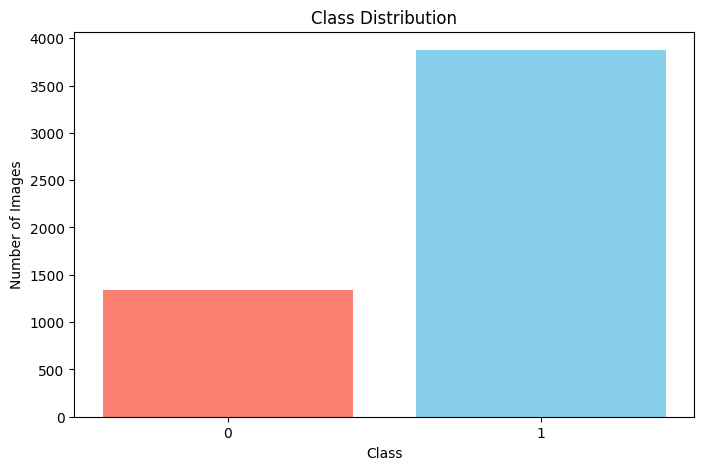

In [ ]:
# 1. Class Distribution (⭐ RUN ONLY ONCE)

from collections import Counter

# Function to plot class distribution
def plot_class_distribution(data_loader):
    # Initializing a list to hold all labels
    all_labels = []

    # Iterating over the DataLoader to collect all labels
    for _, labels in data_loader:
        all_labels.extend(labels.numpy())  # Converting labels to NumPy array and adding to the list

    # Counting occurrences of each class
    class_counts = Counter(all_labels)

    # Extracting class labels and their respective counts
    class_labels = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting the class distribution
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, counts, color=['skyblue', 'salmon'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(class_labels)  # Setting x-ticks to class labels
    plt.show()

# Calling the function for the training DataLoader
plot_class_distribution(pneumo_train_loader)

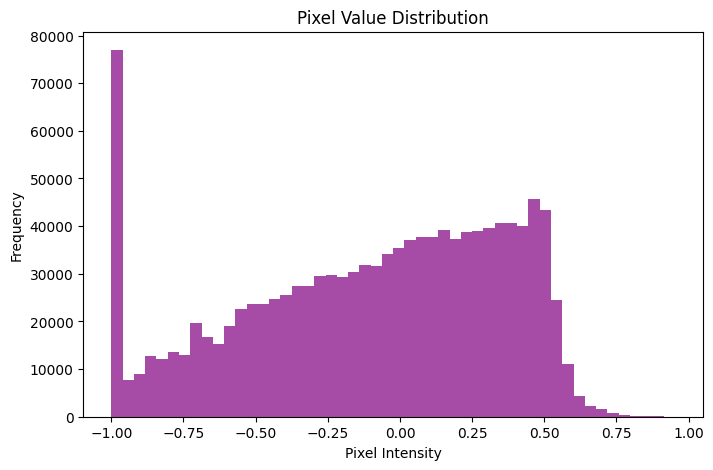

In [ ]:
# 2. Image Characteristics - Image Shape and Pixel Value Distribution (⭐ RUN ONLY ONCE)

# Function to plot pixel value distribution
def plot_pixel_distribution(data_loader):
    # Taking a sample batch to analyze pixel values
    # We will get one batch from the data_loader
    sample_batch, _ = next(iter(data_loader))  # Getting the first batch of images and labels

    # Flattening the pixel values of the images
    pixel_values = sample_batch.flatten()

    plt.figure(figsize=(8, 5))
    plt.hist(pixel_values.numpy(), bins=50, color='purple', alpha=0.7)  # Converting to numpy
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Calling the function for the training DataLoader
plot_pixel_distribution(pneumo_train_loader)

<br>
<br>

**Lung Cancer : CT-Scan** 🔽

In [5]:
# Defining the path to the dataset
base_dir_2 = r'Datasets/Lung_Cancer_CT_Scan_Extracted'

# Setting up parameters
img_height, img_width = 224, 224  # Desired dimensions for resizing
batch_size = 8

# Defining transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resizing images
    transforms.ToTensor(),  # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing pixel values to [-1, 1]
])

# Loading training data
lung_cancer_train_dataset = datasets.ImageFolder(
    os.path.join(base_dir_2, 'train'),  # Path to training images
    transform=transform
)

lung_cancer_train_loader = DataLoader(
    lung_cancer_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Loading validation data
lung_cancer_val_dataset = datasets.ImageFolder(
    os.path.join(base_dir_2, 'val'),  # Path to validation images
    transform=transform
)

lung_cancer_val_loader = DataLoader(
    lung_cancer_val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Loading testing data
lung_cancer_test_dataset = datasets.ImageFolder(
    os.path.join(base_dir_2, 'test'),  # Path to testing images
    transform=transform
)

lung_cancer_test_loader = DataLoader(
    lung_cancer_test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Displaying the class indices and the number if images in each DataLoader
print("lung_cancer_train_loader (class indices) : ", lung_cancer_train_dataset.class_to_idx)
print(f"Number of training images : {len(lung_cancer_train_dataset)}")
print("lung_cancer_val_loader (class indices) : ", lung_cancer_val_dataset.class_to_idx)
print(f"Number of validation images : {len(lung_cancer_val_dataset)}")
print("lung_cancer_test_loader (class indices) : ", lung_cancer_test_dataset.class_to_idx)
print(f"Number of testing images : {len(lung_cancer_test_dataset)}")

lung_cancer_train_loader (class indices) :  {'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum': 3}
Number of training images : 613
lung_cancer_val_loader (class indices) :  {'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum': 3}
Number of validation images : 72
lung_cancer_test_loader (class indices) :  {'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum': 3}
Number of testing images : 315


In [6]:
# Verifying the Image Dimensions

# Function to verify image dimensions and labels
def verify_image_dimensions(data_loader, name):
    # Getting a batch of images and labels
    images, labels = next(iter(data_loader))

    print(f"\n{name} 🔻")
    # Printing the shape of the images and labels
    print(f"Shape of images in batch: {images.shape}")  # Shape: [batch_size, channels, height, width]
    print(f"Labels for the batch: {labels}")

# Verifying dimensions for each DataLoader
verify_image_dimensions(lung_cancer_train_loader, "Training DataLoader")
verify_image_dimensions(lung_cancer_val_loader, "Validation DataLoader")
verify_image_dimensions(lung_cancer_test_loader, "Test DataLoader")


Training DataLoader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([2, 1, 0, 2, 2, 0, 3, 0])

Validation DataLoader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Test DataLoader 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])


<br>
<br>

**Image Data Analysis on Training Generator - Lung Cancer : CT-Scan**

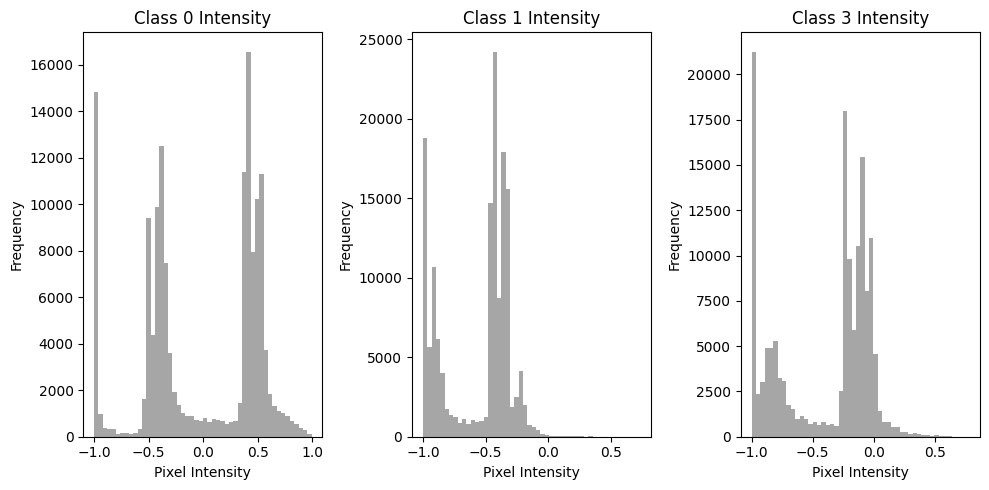

In [ ]:
# 1. Slice Intensity Distribution & Texture Analysis (⭐ RUN ONLY ONCE)

def plot_intensity_distribution_by_class(data_loader):
    # Getting one batch of images and labels
    sample_batch, labels = next(iter(data_loader))

    # Class indices are already in the form of integer labels
    class_indices = labels.numpy()  # Converting labels to numpy array

    # Identifying the unique classes
    unique_classes = np.unique(class_indices)

    # Setting the figure size
    plt.figure(figsize=(10, 5))

    # Initializing a counter for subplot positions
    plot_index = 1

    # Looping through each class and plotting intensity histogram for one sample of each
    for class_id in unique_classes:
        # Selecting the first image that matches the current class
        class_indices_list = np.where(class_indices == class_id)[0]
        if len(class_indices_list) > 0:
            image = sample_batch[class_indices_list[0]].numpy()  # Converting to numpy for plotting
            # Flattening and scaling pixel values if needed (e.g., from [0,1] to [0,255])
            image_flat = (image * 255).flatten() if image.min() >= 0 and image.max() <= 1 else image.flatten()

            # Generating the subplot for the current class
            plt.subplot(1, len(unique_classes), plot_index)
            plt.hist(image_flat, bins=50, color='gray', alpha=0.7)
            plt.title(f'Class {class_id} Intensity')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')

            # Incrementing the plot index for the next subplot
            plot_index += 1

    # Tight layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Running the function for the lung cancer training DataLoader
plot_intensity_distribution_by_class(lung_cancer_train_loader)

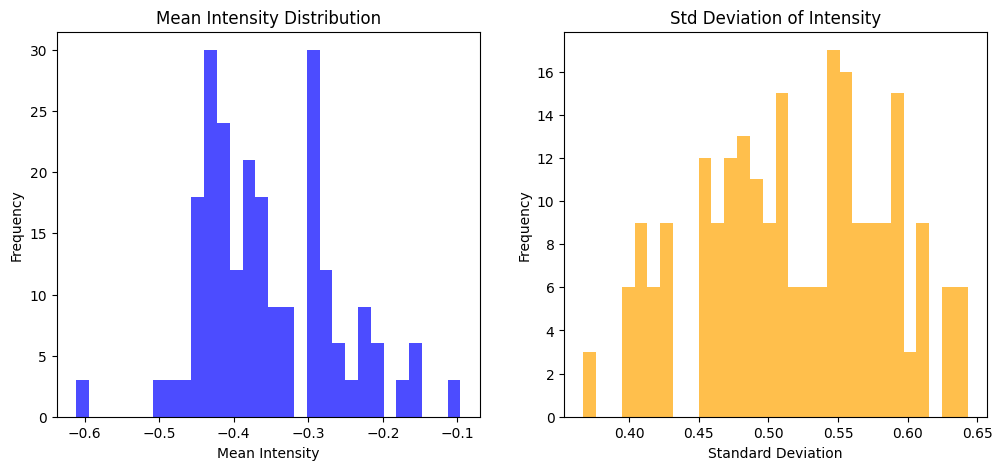

In [ ]:
# 2. Statistical Analysis Across Image Slices (⭐ RUN ONLY ONCE)

def compute_intensity_stats(data_loader):
    mean_intensities = []
    std_intensities = []

    # Iterating over the DataLoader
    for images, labels in data_loader:
        # Calculating mean and standard deviation for the batch
        mean_batch = images.mean(dim=(0, 2, 3))  # Mean across channels, height, and width
        std_batch = images.std(dim=(0, 2, 3))    # Std across channels, height, and width

        mean_intensities.append(mean_batch.numpy())  # Converting to NumPy for easier handling
        std_intensities.append(std_batch.numpy())    # Converting to NumPy for easier handling

    mean_intensities = np.concatenate(mean_intensities)
    std_intensities = np.concatenate(std_intensities)

    # Plotting the mean and standard deviation distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(mean_intensities, bins=30, color='blue', alpha=0.7)
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(std_intensities, bins=30, color='orange', alpha=0.7)
    plt.title('Std Deviation of Intensity')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Frequency')

    plt.show()

# Running the function for the lung cancer training DataLoader
compute_intensity_stats(lung_cancer_train_loader)

<br>
<br>

**Tuberculosis - Chest X-Ray** 🔽

In [7]:
# Defining path to the split dataset
base_dir_3 = r'Datasets/Tuberculosis_Chest_X_Ray_Extracted_Split'

# Setting up parameters
img_height, img_width = 224, 224
batch_size = 8

# Defining transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Resizing images
    transforms.ToTensor(),  # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing pixel values to [-1, 1]
])

# Loading training data
tb_train_dataset = datasets.ImageFolder(
    os.path.join(base_dir_3, 'train'),  # Path to training images
    transform=transform
)

tb_train_loader = DataLoader(
    tb_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Loading validation data
tb_val_dataset = datasets.ImageFolder(
    os.path.join(base_dir_3, 'val'),  # Path to validation images
    transform=transform
)

tb_val_loader = DataLoader(
    tb_val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Loading testing data
tb_test_dataset = datasets.ImageFolder(
    os.path.join(base_dir_3, 'test'),  # Path to testing images
    transform=transform
)

tb_test_loader = DataLoader(
    tb_test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Displaying the class indices
print("tb_train_loader (class indices):", tb_train_dataset.class_to_idx)
print("tb_val_loader (class indices):", tb_val_dataset.class_to_idx)
print("tb_test_loader (class indices):", tb_test_dataset.class_to_idx)

# Displaying the number of images in each loader
print(f"Number of training images: {len(tb_train_loader.dataset)}")
print(f"Number of validation images: {len(tb_val_loader.dataset)}")
print(f"Number of testing images: {len(tb_test_loader.dataset)}")

tb_train_loader (class indices): {'Normal': 0, 'Tuberculosis': 1}
tb_val_loader (class indices): {'Normal': 0, 'Tuberculosis': 1}
tb_test_loader (class indices): {'Normal': 0, 'Tuberculosis': 1}
Number of training images: 2938
Number of validation images: 630
Number of testing images: 632


In [8]:
# Verifying the Image Dimensions

# Function to verify image dimensions
def verify_image_dimensions(data_loader, loader_name):
    # Getting a batch of images and labels
    for images, labels in data_loader:
        # Printing the shape of the images and labels
        print(f"\n{loader_name} 🔻")
        print(f"Shape of images in batch: {images.shape}")  # Shape: (batch_size, channels, height, width)
        print(f"Labels for the batch: {labels}")
        break  # We only need the first batch

# Verifying image dimensions for each DataLoader

# Training DataLoader
verify_image_dimensions(tb_train_loader, "Training Generator")

# Test DataLoader
verify_image_dimensions(tb_test_loader, "Test Generator")

# Validation DataLoader
verify_image_dimensions(tb_val_loader, "Validation Generator")


Training Generator 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 1])

Test Generator 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])

Validation Generator 🔻
Shape of images in batch: torch.Size([8, 3, 224, 224])
Labels for the batch: tensor([0, 0, 0, 0, 0, 0, 0, 0])


<br>
<br>

**Image Data Analysis on Training Generator - Tuberculosis : Chest (X-Ray)**

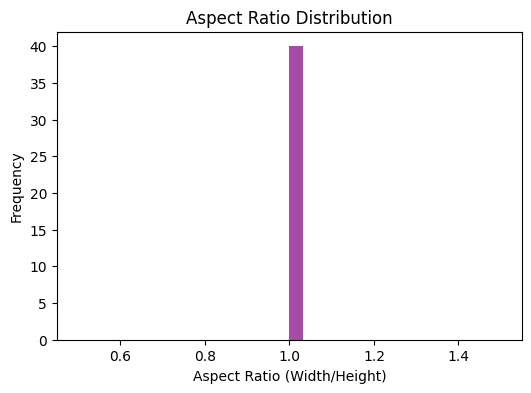

In [ ]:
# 1. Aspect Ratio Analysis (⭐ RUN ONLY ONCE)

def analyze_aspect_ratios(data_loader, num_batches=5):
    # Initializing an empty list to store aspect ratios
    aspect_ratios = []

    # Looping through a specified number of batches from the DataLoader
    for _ in range(num_batches):
        # Getting a batch of images from the DataLoader
        images, _ = next(iter(data_loader))  # `_` is used as we don't need labels here

        # Looping through each image in the batch
        for img in images:
            # Getting the height and width of the image
            height, width = img.shape[1:3]  # Since PyTorch tensors are in (N, C, H, W) format
            # Calculating the aspect ratio (width divided by height)
            aspect_ratios.append(width / height)

    # Plotting the distribution of aspect ratios
    plt.figure(figsize=(6, 4))
    plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Frequency")
    plt.show()

# Calling the function to analyze and plot aspect ratios in the training set
analyze_aspect_ratios(tb_train_loader)

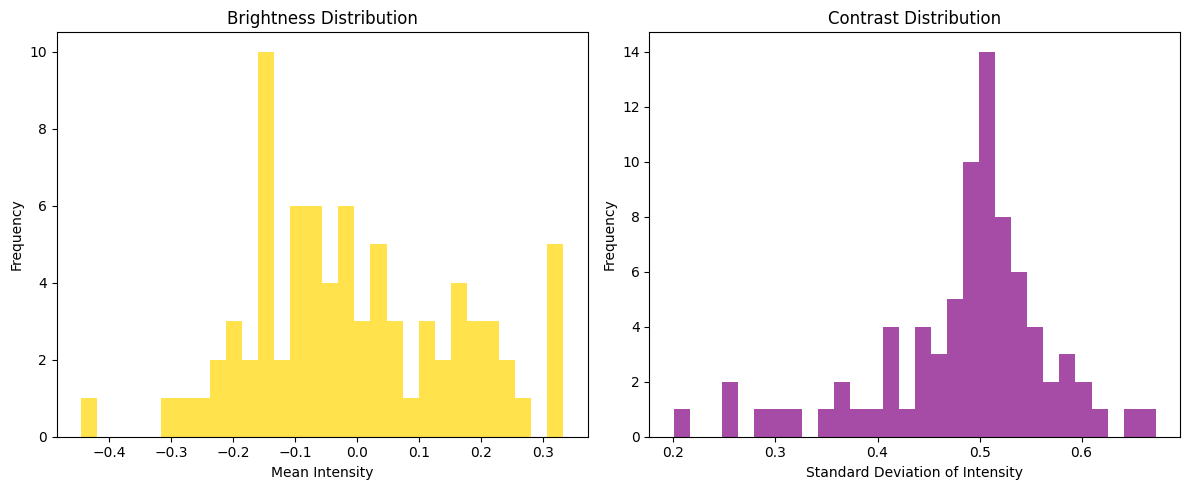

In [ ]:
# 2. Image Brightness and Contrast Analysis (⭐ RUN ONLY ONCE)

def analyze_brightness_contrast(data_loader, num_images=10):
    brightness = []
    contrast = []

    # Looping through the specified number of images
    for _ in range(num_images):
        images, _ = next(iter(data_loader))  # Getting the next batch of images
        for img in images:
            # Converting the tensor to a NumPy array
            img_np = img.numpy()  # Converting to NumPy array

            # Calculating brightness as the mean pixel intensity
            brightness.append(np.mean(img_np))
            # Calculating contrast as the standard deviation of pixel intensities
            contrast.append(np.std(img_np))

    plt.figure(figsize=(12, 5))

    # Brightness Distribution
    plt.subplot(1, 2, 1)
    plt.hist(brightness, bins=30, color='gold', alpha=0.7)
    plt.title("Brightness Distribution")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Frequency")

    # Contrast Distribution
    plt.subplot(1, 2, 2)
    plt.hist(contrast, bins=30, color='purple', alpha=0.7)
    plt.title("Contrast Distribution")
    plt.xlabel("Standard Deviation of Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Calling the function to analyze brightness and contrast in the training set
analyze_brightness_contrast(tb_train_loader)

<br>
<br>

#### **Viewing some of the loaded images from each disease categories**

Training Data Loader Images:


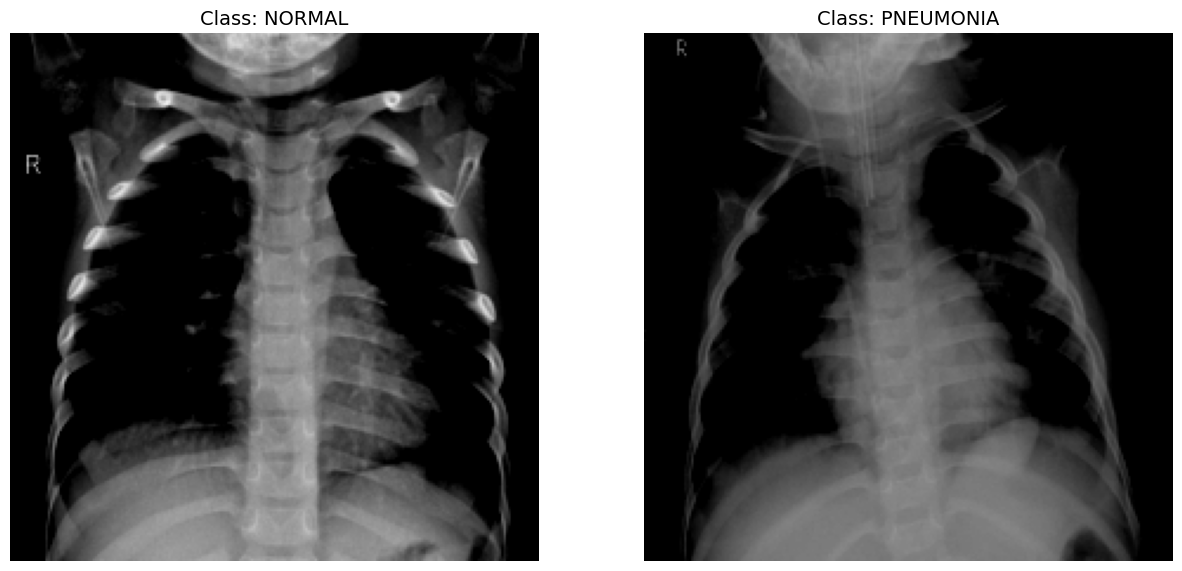

Validation Data Loader Images:


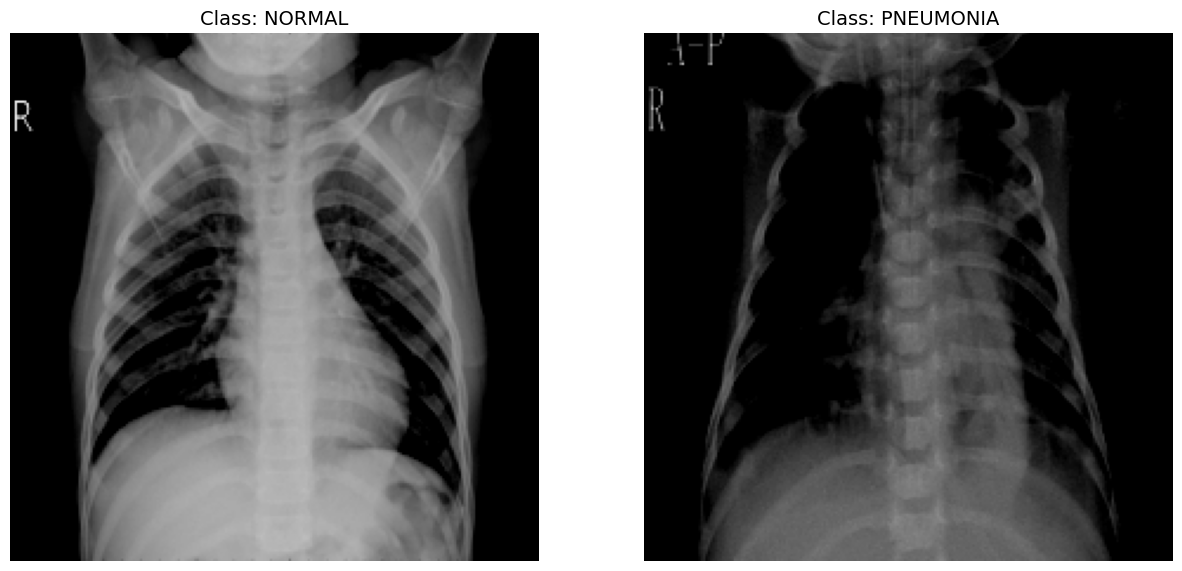

Testing Data Loader Images:


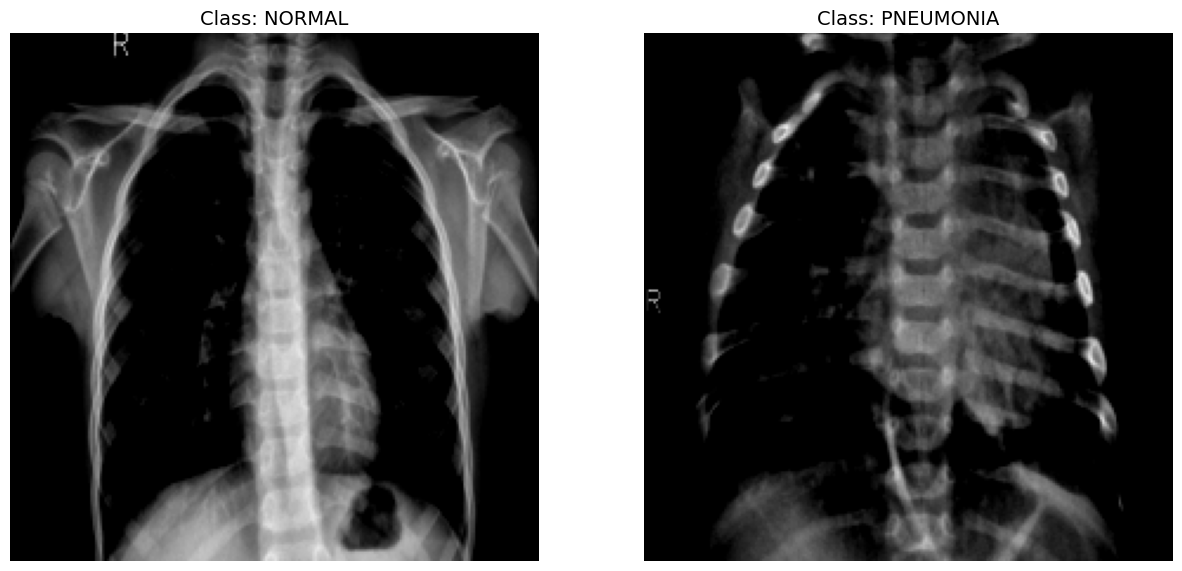

In [ ]:
'''
1. Pneumonia : Chest (X-Ray) (⭐ RUN ONLY ONCE)
'''

# Function to display one image per class from the data loader
def show_images_per_class_1(data_loader, class_indices, num_classes=2):
    # Creating a figure to hold the images
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 7))
    for class_idx in range(num_classes):
        # Getting one image from the specified class
        for images, labels in data_loader:
            # Finding the images that match the class index
            class_images = images[labels == class_idx]
            if len(class_images) > 0:
                # Displaying the first image from this class
                axes[class_idx].imshow(class_images[0].permute(1, 2, 0).numpy())  # Converting from tensor to numpy
                # Adding the class name as title (if you have a mapping of indices to class names)
                class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
                axes[class_idx].set_title(f'Class: {class_name}', fontsize=14)
                axes[class_idx].axis('off')
                break  # Only need one image per class
    plt.show()

# Showing one image per class from the training data loader
print("Training Data Loader Images:")
show_images_per_class_1(pneumo_train_loader, pneumo_train_dataset.class_to_idx)

# Showing one image per class from the validation data loader
print("Validation Data Loader Images:")
show_images_per_class_1(pneumo_val_loader, pneumo_val_dataset.class_to_idx)

# Showing one image per class from the testing data loader
print("Testing Data Loader Images:")
show_images_per_class_1(pneumo_test_loader, pneumo_test_dataset.class_to_idx)

Training Data Loader Images:


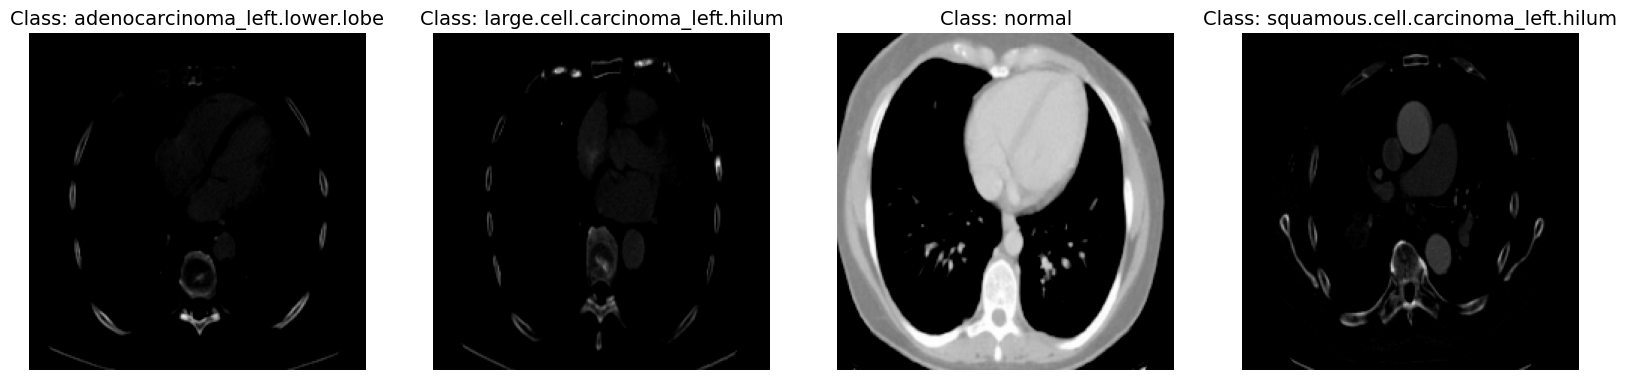

Validation Data Loader Images:


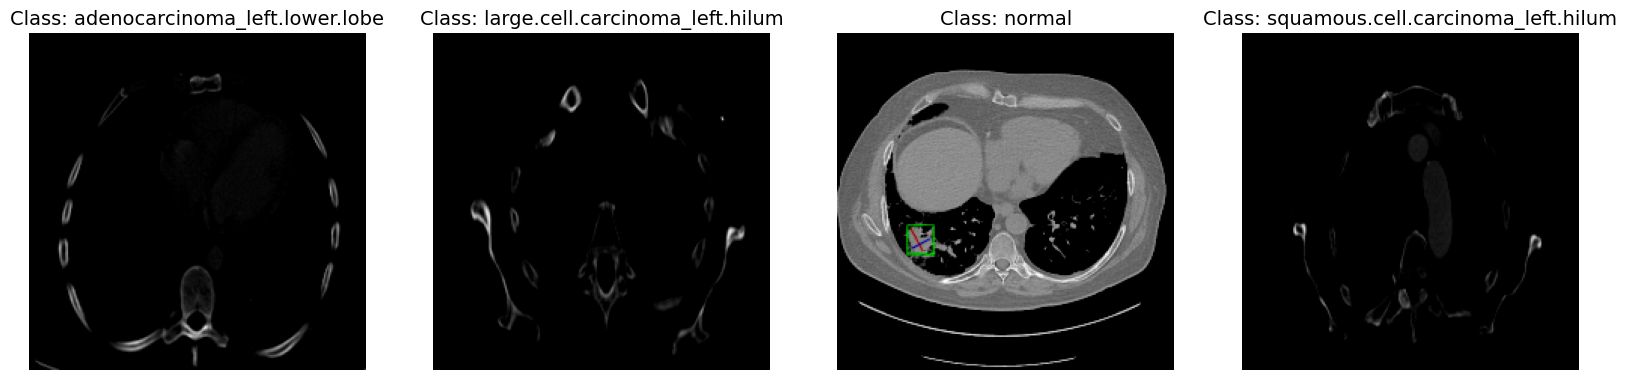

Testing Data Loader Images:


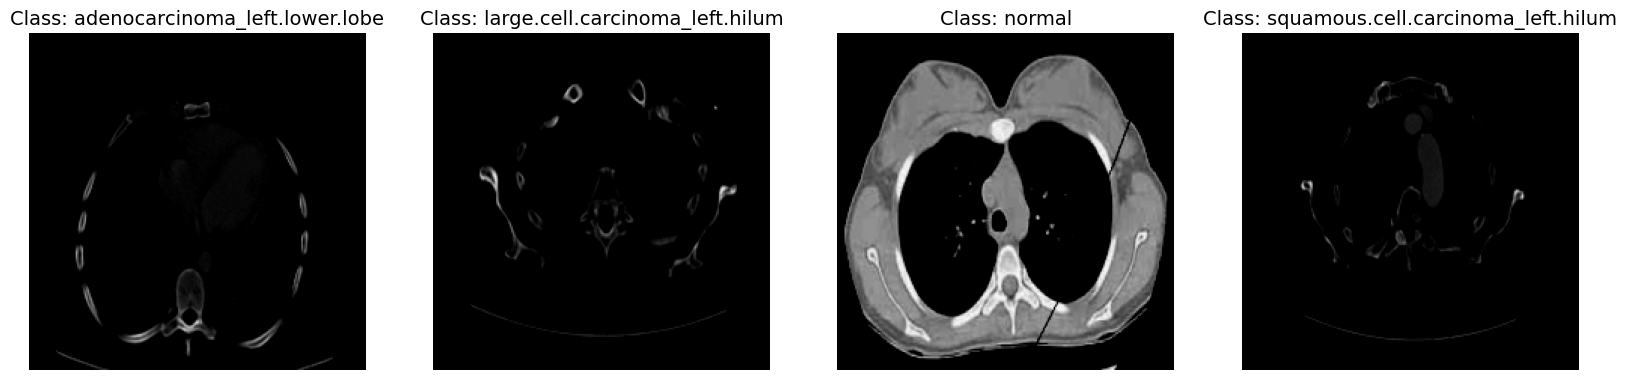

In [ ]:
'''
2. Lung Cancer : CT-Scan (⭐ RUN ONLY ONCE)
'''

# Function to display one image per class from the data loader
def show_images_per_class_2(data_loader, class_indices, num_classes=4):
    # Creating a figure to hold the images
    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))  # Adjusted figsize for better viewing
    for class_idx in range(num_classes):
        # Getting one image from the specified class
        for images, labels in data_loader:
            # Finding the images that match the class index
            class_images = images[labels == class_idx]
            if len(class_images) > 0:
                # Displaying the first image from this class
                axes[class_idx].imshow(class_images[0].permute(1, 2, 0).numpy())  # Converting from tensor to numpy
                # Adding the class name as title
                class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
                axes[class_idx].set_title(f'Class: {class_name}', fontsize=14)
                axes[class_idx].axis('off')
                break  # Only need one image per class
    plt.show()

# Showing one image per class from the training data loader
print("Training Data Loader Images:")
show_images_per_class_2(lung_cancer_train_loader, lung_cancer_train_dataset.class_to_idx)

# Showing one image per class from the validation data loader
print("Validation Data Loader Images:")
show_images_per_class_2(lung_cancer_val_loader, lung_cancer_val_dataset.class_to_idx)

# Showing one image per class from the testing data loader
print("Testing Data Loader Images:")
show_images_per_class_2(lung_cancer_test_loader, lung_cancer_test_dataset.class_to_idx)

Training Data Loader Images:


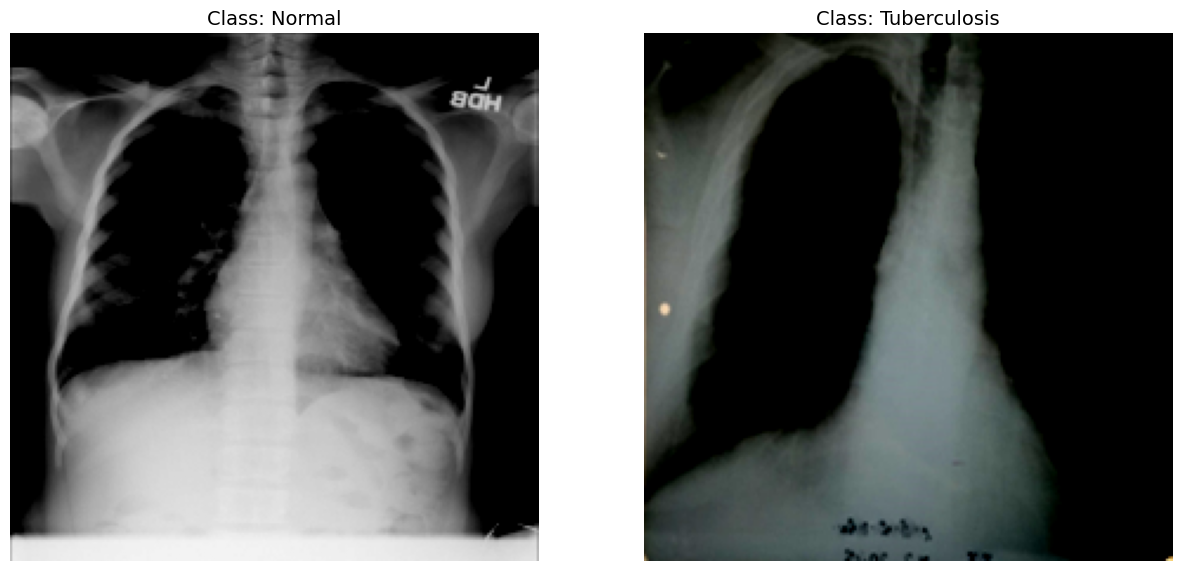

Validation Data Loader Images:


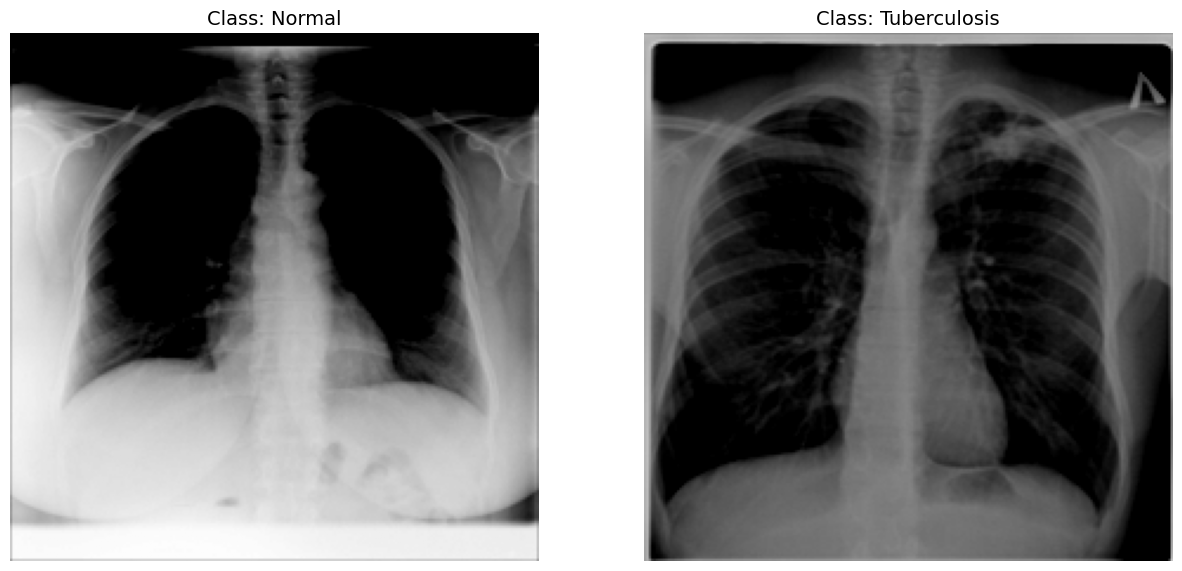

Testing Data Loader Images:


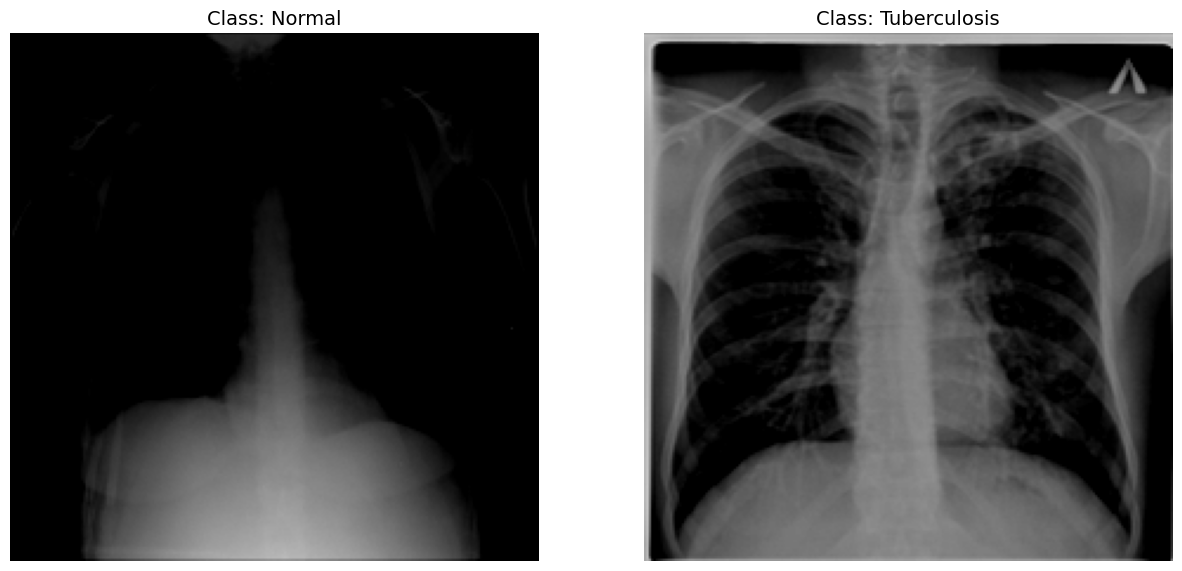

In [ ]:
'''
3. Tuberculosis : Chest (X-ray) (⭐ RUN ONLY ONCE)
'''

# Function to display one image per class from the data loader
def show_images_per_class_3(data_loader, class_indices, num_classes=2):
    # Creating a figure to hold the images
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 7))  # Adjusted figsize for better viewing
    for class_idx in range(num_classes):
        # Getting one image from the specified class
        for images, labels in data_loader:
            # Finding the images that match the class index
            class_images = images[labels == class_idx]
            if len(class_images) > 0:
                # Displaying the first image from this class
                axes[class_idx].imshow(class_images[0].permute(1, 2, 0).numpy())  # Converting from tensor to numpy
                # Adding the class name as title
                class_name = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
                axes[class_idx].set_title(f'Class: {class_name}', fontsize=14)
                axes[class_idx].axis('off')
                break  # Only need one image per class
    plt.show()

# Showing one image per class from the training data loader
print("Training Data Loader Images:")
show_images_per_class_3(tb_train_loader, tb_train_dataset.class_to_idx)

# Showing one image per class from the validation data loader
print("Validation Data Loader Images:")
show_images_per_class_3(tb_val_loader, tb_val_dataset.class_to_idx)

# Showing one image per class from the testing data loader
print("Testing Data Loader Images:")
show_images_per_class_3(tb_test_loader, tb_test_dataset.class_to_idx)

### **STEP - 3 : Image Preprocessing**

In [9]:
# Displaying class indices and dataset sizes (Only for Training Dataset Components) (⭐ RUN ONLY ONCE)

print("pneumo_train_loader (class indices):", pneumo_train_dataset.class_to_idx)
print("Number of training images in pneumonia dataset:", len(pneumo_train_dataset))
print("lung_cancer_train_loader (class indices):", lung_cancer_train_dataset.class_to_idx)
print("Number of training images in lung cancer dataset:", len(lung_cancer_train_dataset))
print("tb_train_loader (class indices):", tb_train_dataset.class_to_idx)
print("Number of training images in tuberculosis dataset:", len(tb_train_dataset))

pneumo_train_loader (class indices): {'NORMAL': 0, 'PNEUMONIA': 1}
Number of training images in pneumonia dataset: 5216
lung_cancer_train_loader (class indices): {'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum': 3}
Number of training images in lung cancer dataset: 613
tb_train_loader (class indices): {'Normal': 0, 'Tuberculosis': 1}
Number of training images in tuberculosis dataset: 2938


In [10]:
# Function to print image dimensions, batch size, and channel information (⭐ RUN ONLY ONCE)
def print_image_dimensions_and_channels(data_loaders, dataset_name):
    print(f"\n{dataset_name}:")
    for loader_name, loader in data_loaders.items():
        for images, labels in loader:
            print(f"{loader_name} - Image batch shape: {images.shape}")
            print(f"Batch size: {images.shape[0]} | Channels: {images.shape[1]} | Height: {images.shape[2]} | Width: {images.shape[3]}")
            break  # Just inspecting the first batch for each loader

# Data loaders for each dataset
data_loaders = {
    'Pneumonia': {
        'pneumo_train_loader': pneumo_train_loader,
        'pneumo_test_loader': pneumo_test_loader,
        'pneumo_val_loader': pneumo_val_loader
    },
    'Tuberculosis': {
        'tb_train_loader': tb_train_loader,
        'tb_test_loader': tb_test_loader,
        'tb_val_loader': tb_val_loader
    },
    'Lung Cancer': {
        'lung_cancer_train_loader': lung_cancer_train_loader,
        'lung_cancer_test_loader': lung_cancer_test_loader,
        'lung_cancer_val_loader': lung_cancer_val_loader
    }
}

# Calling the function for each dataset
for dataset_name, loaders in data_loaders.items():
    print_image_dimensions_and_channels(loaders, dataset_name)


Pneumonia:
pneumo_train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
pneumo_test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
pneumo_val_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224

Tuberculosis:
tb_train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
tb_test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
tb_val_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224

Lung Cancer:
lung_cancer_train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
lung_cancer_test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channel

In [11]:
'''
Below are the Image Preprocessing methods that will be applied to the images of the dataloaders🔻

1. Histogram Equalization
2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
3. Gaussian Blur
4. Resizing with Anti-Aliasing
5. Edge Enhancement (Sharpening)
6. Intensity Normalization
7. Tensor Conversion and Normalization to [-1, 1] Range
8. Brightness and Contrast
'''

'\nBelow are the Image Preprocessing methods that will be applied to the images of the dataloaders🔻\n1. Histogram Equalization\n2. CLAHE (Contrast Limited Adaptive Histogram Equalization)\n3. Gaussian Blur\n4. Resizing with Anti-Aliasing\n5. Edge Enhancement (Sharpening)\n6. Intensity Normalization\n7. Tensor Conversion and Normalization to [-1, 1] Range\n8. Brightness and Contrast\n'

In [12]:
# Putting Data Preprocessing methods to work

# Defining parameters
img_height, img_width = 224, 224  # Desired dimensions for resizing
batch_size = 8

# Preprocessing functions
def adjust_brightness_contrast(image, alpha=1.2, beta=50):
    """
    Adjusting brightness and contrast of the image.
    Parameters:
        - image: Input image (numpy array).
        - alpha: Contrast control [1.0-3.0].
        - beta: Brightness control [0-100].
    Returns:
        - Adjusted image.
    """
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_histogram_equalization(image):
    """Applying histogram equalization to enhance contrast."""
    channels = cv2.split(image)
    eq_channels = [cv2.equalizeHist(ch) for ch in channels]
    return cv2.merge(eq_channels)

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Applying CLAHE for local contrast enhancement."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(ch) for ch in channels]
    return cv2.merge(clahe_channels)

def apply_gaussian_blur(image, kernel_size=(3, 3)):
    """Applying Gaussian blur for denoising."""
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_sharpening(image):
    """Applying edge enhancement using a sharpening filter."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def normalize_image(image):
    """Normalizing the image to zero mean and unit variance."""
    image = (image - np.mean(image)) / np.std(image)
    return image

def resize_image(image, width, height):
    """Resizing the image to the desired dimensions with anti-aliasing."""
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

# Data Augmentation Pipeline
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # Horizontal flip
    transforms.RandomRotation(30),            # Random rotation
    transforms.RandomResizedCrop(224),        # Random crop and resize
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),  # Random color adjustment
    transforms.ToTensor(),                    # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing for RGB
])

val_test_transforms = transforms.Compose([
    transforms.Resize(224),                  # Resizing for validation and test
    transforms.ToTensor(),                   # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing for RGB
])

# Custom dataset class with preprocessing and data augmentation
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.classes = sorted(os.listdir(img_dir))  # Getting class names
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Collecting image paths and labels
        for cls_name, label in self.class_to_idx.items():
            class_dir = os.path.join(img_dir, cls_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Loading the image in RGB format
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as BGR
        if image is None:
            raise ValueError(f"Image not found: {img_path}")

        # Converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Applying preprocessing steps
        image = apply_histogram_equalization(image)
        image = apply_clahe(image)
        image = apply_gaussian_blur(image)
        image = apply_sharpening(image)

        # Adjusting brightness and contrast
        image = adjust_brightness_contrast(image, alpha=1.2, beta=50)

        # Resizing image
        image = resize_image(image, img_width, img_height)

        # Normalizing image
        image = normalize_image(image)

        # Converting to PIL Image for transformations
        image = Image.fromarray(image.astype(np.uint8))

        # Applying the transformation (augmentation or normalizing)
        if self.transform:
            image = self.transform(image)

        # Getting label
        label = self.labels[idx]

        return image, label


# Function to create data loaders with the applied preprocessing techniques and data augmentation
def create_data_loaders(base_dirs, batch_size=8):
    data_loaders = {}

    for dataset_name, base_dir in base_dirs.items():
        # Creating datasets
        train_dataset = CustomImageDataset(os.path.join(base_dir, 'train'), transform=train_transforms)
        test_dataset = CustomImageDataset(os.path.join(base_dir, 'test'), transform=val_test_transforms)
        val_dataset = CustomImageDataset(os.path.join(base_dir, 'val'), transform=val_test_transforms)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


        # Storing the data loaders for later use
        data_loaders[dataset_name] = {
            'train_loader': train_loader,
            'test_loader': test_loader,
            'val_loader': val_loader
        }

    return data_loaders

# Dataset paths
base_dirs = {
    "Pneumonia": r'Datasets/Pneumonia_Chest_X_Ray_Extracted',
    "Lung Cancer": r'Datasets/Lung_Cancer_CT_Scan_Extracted',
    "Tuberculosis": r'Datasets/Tuberculosis_Chest_X_Ray_Extracted_Split'
}

# Creating data loaders with preprocessing and data augmentation
data_loaders = create_data_loaders(base_dirs, batch_size)

# Function to print image dimensions, batch size, and channel information
def print_image_dimensions_and_channels(data_loaders, dataset_name):
    print(f"\n{dataset_name}:")
    for loader_name, loader in data_loaders.items():
        for images, labels in loader:
            print(f"{loader_name} - Image batch shape: {images.shape}")
            print(f"Batch size: {images.shape[0]} | Channels: {images.shape[1]} | Height: {images.shape[2]} | Width: {images.shape[3]}")
            break  # Just inspecting the first batch for each loader

# Calling the function for each dataset
for dataset_name, loaders in data_loaders.items():
    print_image_dimensions_and_channels(loaders, dataset_name)


Pneumonia:
train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
val_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224

Lung Cancer:
train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
val_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224

Tuberculosis:
train_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
test_loader - Image batch shape: torch.Size([8, 3, 224, 224])
Batch size: 8 | Channels: 3 | Height: 224 | Width: 224
val_loader - Image bat

<br>
<br>

### **STEP - 4 : Model Selection and Architecture Development**

In [13]:
from torchvision.models import densenet121
from torchvision.transforms import Resize

# Simplified ViT-like transformer module
class SimpleViT(nn.Module):
    def __init__(self, input_dim, num_heads, mlp_dim, num_layers):
        super(SimpleViT, self).__init__()
        # Reduced TransformerEncoder layer complexity
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=num_heads,
                dim_feedforward=mlp_dim,
                dropout=0.1
            ) for _ in range(num_layers)
        ])

    def forward(self, x):
        # Flattening the spatial dimensions
        B, C, H, W = x.shape
        x = x.flatten(2).permute(2, 0, 1)  # Reshaping for transformer
        for block in self.transformer_blocks:
            x = block(x)
        x = x.permute(1, 2, 0).reshape(B, C, H, W)  # Restoring the original shape
        return x


# Adjusted Hybrid DenseNet + Simplified ViT Architecture
class LightweightHybridDenseNetViT(nn.Module):
    def __init__(self):
        super(LightweightHybridDenseNetViT, self).__init__()

        # Loading a lighter DenseNet backbone
        self.densenet = densenet121(pretrained=False)  # Base DenseNet backbone

        # Reducing the output channels from DenseNet to smaller dimensions
        self.conv_reduce = nn.Conv2d(1024, 64, kernel_size=1)  # Fewer channels

        # ViT processing module with reduced complexity
        self.vit = SimpleViT(input_dim=64, num_heads=2, mlp_dim=128, num_layers=1)

        # Task-specific classification heads
        self.fc_pneumonia = nn.Linear(64, 1)  # Binary classification (Pneumonia)
        self.fc_tuberculosis = nn.Linear(64, 1)  # Binary classification (Tuberculosis)
        self.fc_lung_cancer = nn.Linear(64, 4)  # Multi-class output (Lung Cancer)

    def forward(self, x):
        # Extracting DenseNet features
        x = self.densenet.features(x)  # Extracting DenseNet feature maps
        x = self.conv_reduce(x)  # Reducing the number of feature channels

        # Passing through simplified ViT module
        x = self.vit(x)

        # Applying Global Average Pooling (GAP)
        x = x.mean(dim=[2, 3])  # Pooling across spatial dimensions

        # Task-specific classification
        pneumonia_output = torch.sigmoid(self.fc_pneumonia(x))  # Binary sigmoid output
        tuberculosis_output = torch.sigmoid(self.fc_tuberculosis(x))  # Binary sigmoid output
        lung_cancer_output = self.fc_lung_cancer(x)  # Multi-class logits

        return pneumonia_output, tuberculosis_output, lung_cancer_output

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ", device)

# Example usage (Dummy Input)
model = LightweightHybridDenseNetViT().to(device)
sample_input = torch.randn(8, 3, 224, 224).to(device)  # Batch of 8 images
pneumonia_out, tuberculosis_out, lung_cancer_out = model(sample_input)

print("Pneumonia output:", pneumonia_out.shape)
print("Tuberculosis output:", tuberculosis_out.shape)
print("Lung Cancer output:", lung_cancer_out.shape)

Device :  cpu


e:\anaconda3\envs\CVIP_ENV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\CVIP_ENV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Pneumonia output: torch.Size([8, 1])
Tuberculosis output: torch.Size([8, 1])
Lung Cancer output: torch.Size([8, 4])


<br>
<br>

### <b>STEP - 5 : Model Training and Validation</b>

In [16]:
import torch.optim as optim
from tqdm import tqdm

def calculate_accuracy(predictions, labels, threshold=0.5):
    """Calculating accuracy for binary classification tasks."""
    preds = (predictions > threshold).float()
    return (preds == labels).float().mean().item()

def train_model(model, train_loader_dict, val_loader_dict, num_epochs):

    # Defining optimizers and schedulers
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Defining loss functions
    bce_loss = nn.BCELoss()  # Binary Cross Entropy
    ce_loss = nn.CrossEntropyLoss()  # Cross Entropy Loss

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Metrics placeholders
        train_loss = {"pneumonia": 0, "tuberculosis": 0, "lung_cancer": 0}
        train_acc = {"pneumonia": 0, "tuberculosis": 0, "lung_cancer": 0}
        val_loss = {"pneumonia": 0, "tuberculosis": 0, "lung_cancer": 0}
        val_acc = {"pneumonia": 0, "tuberculosis": 0, "lung_cancer": 0}

        # Training over individual disease loaders
        model.train()
        for task, loader in train_loader_dict.items():
            for inputs, labels in tqdm(loader, desc=f"Training {task.capitalize()}"):
                inputs = inputs.to(device)
                # Handling labels conversion for the specific disease
                if task == 'pneumonia':
                    labels = labels.to(device).float()
                    loss = bce_loss(model(inputs)[0], labels.unsqueeze(1))
                    acc = calculate_accuracy(model(inputs)[0], labels.unsqueeze(1))
                elif task == 'tuberculosis':
                    labels = labels.to(device).float()
                    loss = bce_loss(model(inputs)[1], labels.unsqueeze(1))
                    acc = calculate_accuracy(model(inputs)[1], labels.unsqueeze(1))
                elif task == 'lung_cancer':
                    labels = labels.to(device).long()
                    loss = ce_loss(model(inputs)[2], labels)
                    acc = (model(inputs)[2].argmax(1) == labels).float().mean().item()

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate metrics
                train_loss[task] += loss.item()
                train_acc[task] += acc

        # Average training metrics
        for task in train_loss:
            train_loss[task] /= len(train_loader_dict[task])
            train_acc[task] /= len(train_loader_dict[task])

        # Validation phase
        model.eval()
        with torch.no_grad():
            for task, loader in val_loader_dict.items():
                for inputs, labels in tqdm(loader, desc=f"Validating {task.capitalize()}"):
                    inputs = inputs.to(device)
                    if task == 'pneumonia':
                        labels = labels.to(device).float()
                        loss = bce_loss(model(inputs)[0], labels.unsqueeze(1))
                        acc = calculate_accuracy(model(inputs)[0], labels.unsqueeze(1))
                    elif task == 'tuberculosis':
                        labels = labels.to(device).float()
                        loss = bce_loss(model(inputs)[1], labels.unsqueeze(1))
                        acc = calculate_accuracy(model(inputs)[1], labels.unsqueeze(1))
                    elif task == 'lung_cancer':
                        labels = labels.to(device).long()
                        loss = ce_loss(model(inputs)[2], labels)
                        acc = (model(inputs)[2].argmax(1) == labels).float().mean().item()

                    # Accumulating metrics
                    val_loss[task] += loss.item()
                    val_acc[task] += acc

        # Averaging validation metrics
        for task in val_loss:
            val_loss[task] /= len(val_loader_dict[task])
            val_acc[task] /= len(val_loader_dict[task])

        # Printing metrics
        print("Training Loss and Accuracy:")
        for task in train_loss:
            print(f"  {task.capitalize()} - Loss: {train_loss[task]:.4f}, Accuracy: {train_acc[task] * 100:.2f}%")

        print("Validation Loss and Accuracy:")
        for task in val_loss:
            print(f"  {task.capitalize()} - Loss: {val_loss[task]:.4f}, Accuracy: {val_acc[task] * 100:.2f}%")

        # Stepping the scheduler
        scheduler.step()
    print("Training complete.")

In [17]:
# Training parameters
num_epochs = 100

# Instantiating model
model = LightweightHybridDenseNetViT().to(device)

train_loader = {
    'pneumonia': data_loaders['Pneumonia']['train_loader'],
    'tuberculosis': data_loaders['Tuberculosis']['train_loader'],
    'lung_cancer': data_loaders['Lung Cancer']['train_loader']
}

val_loader = {
    'pneumonia': data_loaders['Pneumonia']['val_loader'],
    'tuberculosis': data_loaders['Tuberculosis']['val_loader'],
    'lung_cancer': data_loaders['Lung Cancer']['val_loader']
}

train_model(model, train_loader, val_loader, num_epochs)

Epoch 1/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:57<00:00,  6.43s/it]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.4485, Accuracy: 79.45%
  Tuberculosis - Loss: 0.3559, Accuracy: 87.40%
  Lung_cancer - Loss: 1.2547, Accuracy: 35.69%
Validation Loss and Accuracy:
  Pneumonia - Loss: 0.6277, Accuracy: 75.00%
  Tuberculosis - Loss: 0.3235, Accuracy: 91.19%
  Lung_cancer - Loss: 1.1734, Accuracy: 40.28%
Epoch 2/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.3980, Accuracy: 82.36%
  Tuberculosis - Loss: 0.2757, Accuracy: 90.50%
  Lung_cancer - Loss: 1.1932, Accuracy: 43.91%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.0123, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3003, Accuracy: 89.74%
  Lung_cancer - Loss: 1.0841, Accuracy: 44.44%
Epoch 3/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.3588, Accuracy: 84.14%
  Tuberculosis - Loss: 0.2600, Accuracy: 91.45%
  Lung_cancer - Loss: 1.1116, Accuracy: 48.03%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.3843, Accuracy: 50.00%
  Tuberculosis - Loss: 1.4662, Accuracy: 27.88%
  Lung_cancer - Loss: 1.1177, Accuracy: 45.83%
Epoch 4/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.3357, Accuracy: 85.39%
  Tuberculosis - Loss: 0.2563, Accuracy: 91.14%
  Lung_cancer - Loss: 1.0960, Accuracy: 49.34%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6812, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3323, Accuracy: 87.50%
  Lung_cancer - Loss: 1.2308, Accuracy: 40.28%
Epoch 5/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.3118, Accuracy: 86.89%
  Tuberculosis - Loss: 0.2479, Accuracy: 91.18%
  Lung_cancer - Loss: 1.0600, Accuracy: 51.64%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.2585, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6471, Accuracy: 69.87%
  Lung_cancer - Loss: 1.1297, Accuracy: 45.83%
Epoch 6/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.3103, Accuracy: 87.15%
  Tuberculosis - Loss: 0.2213, Accuracy: 92.64%
  Lung_cancer - Loss: 1.0180, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.4418, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5441, Accuracy: 76.60%
  Lung_cancer - Loss: 1.1404, Accuracy: 44.44%
Epoch 7/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2880, Accuracy: 87.56%
  Tuberculosis - Loss: 0.2138, Accuracy: 92.81%
  Lung_cancer - Loss: 1.0181, Accuracy: 51.97%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.3866, Accuracy: 50.00%
  Tuberculosis - Loss: 0.8153, Accuracy: 59.29%
  Lung_cancer - Loss: 1.1733, Accuracy: 41.67%
Epoch 8/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2668, Accuracy: 88.98%
  Tuberculosis - Loss: 0.2151, Accuracy: 92.85%
  Lung_cancer - Loss: 1.0242, Accuracy: 52.30%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.1560, Accuracy: 50.00%
  Tuberculosis - Loss: 1.3264, Accuracy: 38.46%
  Lung_cancer - Loss: 1.2516, Accuracy: 36.11%
Epoch 9/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2616, Accuracy: 88.65%
  Tuberculosis - Loss: 0.2010, Accuracy: 93.43%
  Lung_cancer - Loss: 1.0136, Accuracy: 54.28%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.4110, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5485, Accuracy: 72.92%
  Lung_cancer - Loss: 1.1089, Accuracy: 43.06%
Epoch 10/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2641, Accuracy: 89.13%
  Tuberculosis - Loss: 0.2045, Accuracy: 92.92%
  Lung_cancer - Loss: 0.9987, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7067, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4338, Accuracy: 82.37%
  Lung_cancer - Loss: 1.0785, Accuracy: 41.67%
Epoch 11/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2489, Accuracy: 90.34%
  Tuberculosis - Loss: 0.2015, Accuracy: 92.71%
  Lung_cancer - Loss: 0.9996, Accuracy: 56.09%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7082, Accuracy: 50.00%
  Tuberculosis - Loss: 0.8173, Accuracy: 59.46%
  Lung_cancer - Loss: 1.1755, Accuracy: 38.89%
Epoch 12/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2556, Accuracy: 89.59%
  Tuberculosis - Loss: 0.2040, Accuracy: 92.81%
  Lung_cancer - Loss: 0.9943, Accuracy: 51.32%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.5402, Accuracy: 50.00%
  Tuberculosis - Loss: 0.9446, Accuracy: 53.04%
  Lung_cancer - Loss: 1.2818, Accuracy: 37.50%
Epoch 13/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2452, Accuracy: 90.11%
  Tuberculosis - Loss: 0.1933, Accuracy: 93.12%
  Lung_cancer - Loss: 1.0163, Accuracy: 51.48%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7192, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6057, Accuracy: 70.51%
  Lung_cancer - Loss: 1.1613, Accuracy: 38.89%
Epoch 14/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2551, Accuracy: 89.23%
  Tuberculosis - Loss: 0.1952, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9756, Accuracy: 54.61%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6398, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7491, Accuracy: 63.14%
  Lung_cancer - Loss: 1.1783, Accuracy: 40.28%
Epoch 15/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2477, Accuracy: 89.67%
  Tuberculosis - Loss: 0.1959, Accuracy: 93.49%
  Lung_cancer - Loss: 0.9786, Accuracy: 55.10%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8223, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3609, Accuracy: 86.38%
  Lung_cancer - Loss: 1.0880, Accuracy: 44.44%
Epoch 16/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2504, Accuracy: 89.57%
  Tuberculosis - Loss: 0.1949, Accuracy: 93.29%
  Lung_cancer - Loss: 0.9984, Accuracy: 52.63%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.9239, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3149, Accuracy: 88.62%
  Lung_cancer - Loss: 1.0502, Accuracy: 44.44%
Epoch 17/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2552, Accuracy: 89.59%
  Tuberculosis - Loss: 0.1931, Accuracy: 93.02%
  Lung_cancer - Loss: 0.9897, Accuracy: 53.45%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6310, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6939, Accuracy: 65.22%
  Lung_cancer - Loss: 1.1264, Accuracy: 40.28%
Epoch 18/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2533, Accuracy: 89.63%
  Tuberculosis - Loss: 0.1978, Accuracy: 93.32%
  Lung_cancer - Loss: 0.9704, Accuracy: 56.09%
Validation Loss and Accuracy:
  Pneumonia - Loss: 2.0193, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2692, Accuracy: 90.38%
  Lung_cancer - Loss: 1.0737, Accuracy: 43.06%
Epoch 19/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2419, Accuracy: 90.01%
  Tuberculosis - Loss: 0.1941, Accuracy: 93.49%
  Lung_cancer - Loss: 0.9851, Accuracy: 56.09%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7809, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6274, Accuracy: 69.71%
  Lung_cancer - Loss: 1.1871, Accuracy: 40.28%
Epoch 20/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2496, Accuracy: 90.34%
  Tuberculosis - Loss: 0.1952, Accuracy: 93.46%
  Lung_cancer - Loss: 0.9848, Accuracy: 53.62%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8239, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5080, Accuracy: 78.21%
  Lung_cancer - Loss: 1.1332, Accuracy: 40.28%
Epoch 21/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2542, Accuracy: 89.03%
  Tuberculosis - Loss: 0.1991, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9767, Accuracy: 54.11%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7519, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5465, Accuracy: 74.68%
  Lung_cancer - Loss: 1.1154, Accuracy: 43.06%
Epoch 22/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2514, Accuracy: 89.55%
  Tuberculosis - Loss: 0.1974, Accuracy: 92.98%
  Lung_cancer - Loss: 0.9645, Accuracy: 54.93%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8078, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3693, Accuracy: 86.38%
  Lung_cancer - Loss: 1.1175, Accuracy: 41.67%
Epoch 23/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2473, Accuracy: 89.24%
  Tuberculosis - Loss: 0.1891, Accuracy: 93.43%
  Lung_cancer - Loss: 0.9971, Accuracy: 52.14%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7252, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6565, Accuracy: 67.95%
  Lung_cancer - Loss: 1.1487, Accuracy: 41.67%
Epoch 24/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2559, Accuracy: 89.13%
  Tuberculosis - Loss: 0.1993, Accuracy: 92.88%
  Lung_cancer - Loss: 0.9955, Accuracy: 55.10%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6689, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6637, Accuracy: 66.99%
  Lung_cancer - Loss: 1.1711, Accuracy: 40.28%
Epoch 25/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2470, Accuracy: 89.46%
  Tuberculosis - Loss: 0.2024, Accuracy: 93.32%
  Lung_cancer - Loss: 1.0007, Accuracy: 54.61%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6493, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6359, Accuracy: 68.75%
  Lung_cancer - Loss: 1.1772, Accuracy: 40.28%
Epoch 26/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2529, Accuracy: 89.61%
  Tuberculosis - Loss: 0.1991, Accuracy: 93.29%
  Lung_cancer - Loss: 0.9908, Accuracy: 54.44%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7250, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3741, Accuracy: 85.58%
  Lung_cancer - Loss: 1.0810, Accuracy: 43.06%
Epoch 27/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2584, Accuracy: 89.55%
  Tuberculosis - Loss: 0.1968, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9858, Accuracy: 55.76%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8280, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4863, Accuracy: 78.53%
  Lung_cancer - Loss: 1.1178, Accuracy: 40.28%
Epoch 28/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2401, Accuracy: 90.01%
  Tuberculosis - Loss: 0.2000, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9938, Accuracy: 54.44%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6079, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5372, Accuracy: 75.64%
  Lung_cancer - Loss: 1.1211, Accuracy: 41.67%
Epoch 29/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2399, Accuracy: 90.26%
  Tuberculosis - Loss: 0.2000, Accuracy: 92.92%
  Lung_cancer - Loss: 0.9670, Accuracy: 53.62%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6201, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6685, Accuracy: 67.15%
  Lung_cancer - Loss: 1.1415, Accuracy: 38.89%
Epoch 30/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2451, Accuracy: 90.26%
  Tuberculosis - Loss: 0.1992, Accuracy: 93.19%
  Lung_cancer - Loss: 0.9796, Accuracy: 55.92%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8303, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5070, Accuracy: 77.72%
  Lung_cancer - Loss: 1.1125, Accuracy: 40.28%
Epoch 31/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2507, Accuracy: 89.70%
  Tuberculosis - Loss: 0.1951, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9826, Accuracy: 56.41%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.5816, Accuracy: 50.00%
  Tuberculosis - Loss: 0.9656, Accuracy: 52.24%
  Lung_cancer - Loss: 1.1989, Accuracy: 38.89%
Epoch 32/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2445, Accuracy: 89.61%
  Tuberculosis - Loss: 0.1959, Accuracy: 92.88%
  Lung_cancer - Loss: 0.9866, Accuracy: 52.30%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8205, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3483, Accuracy: 87.34%
  Lung_cancer - Loss: 1.0787, Accuracy: 44.44%
Epoch 33/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2433, Accuracy: 89.70%
  Tuberculosis - Loss: 0.2013, Accuracy: 93.05%
  Lung_cancer - Loss: 0.9876, Accuracy: 55.76%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7686, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4390, Accuracy: 81.73%
  Lung_cancer - Loss: 1.1155, Accuracy: 41.67%
Epoch 34/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2548, Accuracy: 89.38%
  Tuberculosis - Loss: 0.2004, Accuracy: 92.98%
  Lung_cancer - Loss: 0.9797, Accuracy: 54.44%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7307, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5859, Accuracy: 72.12%
  Lung_cancer - Loss: 1.1505, Accuracy: 41.67%
Epoch 35/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2544, Accuracy: 89.53%
  Tuberculosis - Loss: 0.2006, Accuracy: 93.15%
  Lung_cancer - Loss: 1.0051, Accuracy: 51.15%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6876, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5394, Accuracy: 75.64%
  Lung_cancer - Loss: 1.1054, Accuracy: 41.67%
Epoch 36/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2478, Accuracy: 89.99%
  Tuberculosis - Loss: 0.1939, Accuracy: 93.46%
  Lung_cancer - Loss: 1.0016, Accuracy: 53.29%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7098, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5094, Accuracy: 77.56%
  Lung_cancer - Loss: 1.1060, Accuracy: 40.28%
Epoch 37/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2552, Accuracy: 89.65%
  Tuberculosis - Loss: 0.1975, Accuracy: 93.02%
  Lung_cancer - Loss: 0.9816, Accuracy: 55.43%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8764, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3190, Accuracy: 88.62%
  Lung_cancer - Loss: 1.1198, Accuracy: 41.67%
Epoch 38/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2407, Accuracy: 89.99%
  Tuberculosis - Loss: 0.1901, Accuracy: 93.39%
  Lung_cancer - Loss: 0.9923, Accuracy: 52.47%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7799, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4238, Accuracy: 82.53%
  Lung_cancer - Loss: 1.1384, Accuracy: 44.44%
Epoch 39/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2489, Accuracy: 89.63%
  Tuberculosis - Loss: 0.2009, Accuracy: 93.02%
  Lung_cancer - Loss: 0.9719, Accuracy: 54.44%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7645, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5443, Accuracy: 74.68%
  Lung_cancer - Loss: 1.1327, Accuracy: 43.06%
Epoch 40/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2436, Accuracy: 89.88%
  Tuberculosis - Loss: 0.1964, Accuracy: 93.12%
  Lung_cancer - Loss: 0.9863, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8441, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4484, Accuracy: 81.09%
  Lung_cancer - Loss: 1.0992, Accuracy: 43.06%
Epoch 41/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2553, Accuracy: 88.80%
  Tuberculosis - Loss: 0.1990, Accuracy: 93.43%
  Lung_cancer - Loss: 0.9886, Accuracy: 54.61%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7469, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3938, Accuracy: 83.81%
  Lung_cancer - Loss: 1.1618, Accuracy: 41.67%
Epoch 42/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2485, Accuracy: 89.78%
  Tuberculosis - Loss: 0.1938, Accuracy: 93.22%
  Lung_cancer - Loss: 0.9699, Accuracy: 55.92%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8627, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2897, Accuracy: 90.22%
  Lung_cancer - Loss: 1.1270, Accuracy: 43.06%
Epoch 43/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2494, Accuracy: 89.46%
  Tuberculosis - Loss: 0.1979, Accuracy: 92.98%
  Lung_cancer - Loss: 1.0005, Accuracy: 52.96%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7068, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5219, Accuracy: 76.92%
  Lung_cancer - Loss: 1.1534, Accuracy: 43.06%
Epoch 44/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2491, Accuracy: 89.67%
  Tuberculosis - Loss: 0.2044, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9944, Accuracy: 52.80%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7848, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3569, Accuracy: 86.54%
  Lung_cancer - Loss: 1.0880, Accuracy: 41.67%
Epoch 45/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2490, Accuracy: 89.69%
  Tuberculosis - Loss: 0.1992, Accuracy: 92.95%
  Lung_cancer - Loss: 1.0063, Accuracy: 53.62%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6338, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6016, Accuracy: 70.51%
  Lung_cancer - Loss: 1.2311, Accuracy: 38.89%
Epoch 46/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2498, Accuracy: 89.23%
  Tuberculosis - Loss: 0.1952, Accuracy: 93.32%
  Lung_cancer - Loss: 0.9946, Accuracy: 52.96%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.9328, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2696, Accuracy: 90.54%
  Lung_cancer - Loss: 1.0640, Accuracy: 43.06%
Epoch 47/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2559, Accuracy: 89.03%
  Tuberculosis - Loss: 0.1984, Accuracy: 93.12%
  Lung_cancer - Loss: 0.9838, Accuracy: 54.93%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.9440, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3446, Accuracy: 87.18%
  Lung_cancer - Loss: 1.0885, Accuracy: 41.67%
Epoch 48/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2549, Accuracy: 89.24%
  Tuberculosis - Loss: 0.1976, Accuracy: 93.32%
  Lung_cancer - Loss: 0.9704, Accuracy: 56.09%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6318, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7533, Accuracy: 62.34%
  Lung_cancer - Loss: 1.1663, Accuracy: 40.28%
Epoch 49/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2491, Accuracy: 89.70%
  Tuberculosis - Loss: 0.2004, Accuracy: 93.12%
  Lung_cancer - Loss: 0.9928, Accuracy: 54.93%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8940, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3222, Accuracy: 87.98%
  Lung_cancer - Loss: 1.0649, Accuracy: 43.06%
Epoch 50/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2425, Accuracy: 89.84%
  Tuberculosis - Loss: 0.2032, Accuracy: 92.81%
  Lung_cancer - Loss: 0.9958, Accuracy: 53.62%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8669, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4312, Accuracy: 81.57%
  Lung_cancer - Loss: 1.1276, Accuracy: 40.28%
Epoch 51/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2543, Accuracy: 89.47%
  Tuberculosis - Loss: 0.1949, Accuracy: 93.12%
  Lung_cancer - Loss: 0.9957, Accuracy: 52.63%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8212, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5306, Accuracy: 75.80%
  Lung_cancer - Loss: 1.1078, Accuracy: 40.28%
Epoch 52/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2561, Accuracy: 89.46%
  Tuberculosis - Loss: 0.1953, Accuracy: 93.43%
  Lung_cancer - Loss: 0.9549, Accuracy: 55.10%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.5987, Accuracy: 50.00%
  Tuberculosis - Loss: 0.9634, Accuracy: 51.44%
  Lung_cancer - Loss: 1.1892, Accuracy: 40.28%
Epoch 53/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2538, Accuracy: 89.70%
  Tuberculosis - Loss: 0.1975, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9839, Accuracy: 52.80%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8459, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4366, Accuracy: 82.05%
  Lung_cancer - Loss: 1.0999, Accuracy: 40.28%
Epoch 54/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2511, Accuracy: 89.70%
  Tuberculosis - Loss: 0.1934, Accuracy: 93.49%
  Lung_cancer - Loss: 0.9694, Accuracy: 55.26%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8280, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3359, Accuracy: 87.66%
  Lung_cancer - Loss: 1.1165, Accuracy: 43.06%
Epoch 55/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2537, Accuracy: 89.55%
  Tuberculosis - Loss: 0.1849, Accuracy: 93.70%
  Lung_cancer - Loss: 0.9713, Accuracy: 55.43%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7213, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5590, Accuracy: 74.20%
  Lung_cancer - Loss: 1.0983, Accuracy: 41.67%
Epoch 56/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2435, Accuracy: 90.18%
  Tuberculosis - Loss: 0.1914, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9732, Accuracy: 52.63%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.9649, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2757, Accuracy: 90.06%
  Lung_cancer - Loss: 1.0696, Accuracy: 44.44%
Epoch 57/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2444, Accuracy: 90.03%
  Tuberculosis - Loss: 0.1965, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9803, Accuracy: 55.59%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8307, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5110, Accuracy: 77.24%
  Lung_cancer - Loss: 1.1930, Accuracy: 41.67%
Epoch 58/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2444, Accuracy: 89.86%
  Tuberculosis - Loss: 0.2003, Accuracy: 92.88%
  Lung_cancer - Loss: 0.9884, Accuracy: 53.78%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7771, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3322, Accuracy: 87.50%
  Lung_cancer - Loss: 1.0886, Accuracy: 44.44%
Epoch 59/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2470, Accuracy: 89.76%
  Tuberculosis - Loss: 0.1932, Accuracy: 93.66%
  Lung_cancer - Loss: 0.9865, Accuracy: 53.45%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7898, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4424, Accuracy: 81.09%
  Lung_cancer - Loss: 1.1036, Accuracy: 43.06%
Epoch 60/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2489, Accuracy: 89.69%
  Tuberculosis - Loss: 0.1983, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9650, Accuracy: 56.74%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6450, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7088, Accuracy: 64.74%
  Lung_cancer - Loss: 1.1643, Accuracy: 41.67%
Epoch 61/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2502, Accuracy: 89.21%
  Tuberculosis - Loss: 0.1921, Accuracy: 93.39%
  Lung_cancer - Loss: 0.9797, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7796, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3183, Accuracy: 88.30%
  Lung_cancer - Loss: 1.0732, Accuracy: 43.06%
Epoch 62/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2526, Accuracy: 89.24%
  Tuberculosis - Loss: 0.1955, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9779, Accuracy: 54.77%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8080, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3720, Accuracy: 86.38%
  Lung_cancer - Loss: 1.0686, Accuracy: 40.28%
Epoch 63/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2545, Accuracy: 89.44%
  Tuberculosis - Loss: 0.1925, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9882, Accuracy: 53.78%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8903, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3477, Accuracy: 87.18%
  Lung_cancer - Loss: 1.0800, Accuracy: 41.67%
Epoch 64/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2488, Accuracy: 89.26%
  Tuberculosis - Loss: 0.1849, Accuracy: 93.56%
  Lung_cancer - Loss: 0.9827, Accuracy: 54.11%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8020, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6387, Accuracy: 68.91%
  Lung_cancer - Loss: 1.1311, Accuracy: 38.89%
Epoch 65/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2479, Accuracy: 90.15%
  Tuberculosis - Loss: 0.1978, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9754, Accuracy: 55.76%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7416, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5508, Accuracy: 74.20%
  Lung_cancer - Loss: 1.1668, Accuracy: 38.89%
Epoch 66/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2599, Accuracy: 89.11%
  Tuberculosis - Loss: 0.1924, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9919, Accuracy: 54.11%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7901, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6186, Accuracy: 69.55%
  Lung_cancer - Loss: 1.1485, Accuracy: 38.89%
Epoch 67/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2499, Accuracy: 89.55%
  Tuberculosis - Loss: 0.2004, Accuracy: 93.32%
  Lung_cancer - Loss: 0.9978, Accuracy: 56.09%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7323, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5936, Accuracy: 70.67%
  Lung_cancer - Loss: 1.1678, Accuracy: 38.89%
Epoch 68/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2537, Accuracy: 89.72%
  Tuberculosis - Loss: 0.1954, Accuracy: 93.29%
  Lung_cancer - Loss: 0.9725, Accuracy: 56.91%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7153, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7704, Accuracy: 60.90%
  Lung_cancer - Loss: 1.1673, Accuracy: 43.06%
Epoch 69/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2524, Accuracy: 89.03%
  Tuberculosis - Loss: 0.2002, Accuracy: 93.29%
  Lung_cancer - Loss: 1.0101, Accuracy: 53.29%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8317, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2331, Accuracy: 91.99%
  Lung_cancer - Loss: 1.1207, Accuracy: 37.50%
Epoch 70/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2443, Accuracy: 90.16%
  Tuberculosis - Loss: 0.1942, Accuracy: 93.46%
  Lung_cancer - Loss: 1.0281, Accuracy: 52.47%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7948, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4931, Accuracy: 78.04%
  Lung_cancer - Loss: 1.1423, Accuracy: 43.06%
Epoch 71/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2425, Accuracy: 90.18%
  Tuberculosis - Loss: 0.1945, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9874, Accuracy: 52.30%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8215, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2820, Accuracy: 89.58%
  Lung_cancer - Loss: 1.0551, Accuracy: 44.44%
Epoch 72/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2527, Accuracy: 89.90%
  Tuberculosis - Loss: 0.1967, Accuracy: 93.43%
  Lung_cancer - Loss: 0.9786, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.9645, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2616, Accuracy: 90.71%
  Lung_cancer - Loss: 1.0651, Accuracy: 45.83%
Epoch 73/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2497, Accuracy: 89.72%
  Tuberculosis - Loss: 0.1948, Accuracy: 93.32%
  Lung_cancer - Loss: 0.9794, Accuracy: 53.78%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7896, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4442, Accuracy: 81.41%
  Lung_cancer - Loss: 1.1245, Accuracy: 41.67%
Epoch 74/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2593, Accuracy: 89.21%
  Tuberculosis - Loss: 0.1933, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9993, Accuracy: 53.62%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8597, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3597, Accuracy: 86.22%
  Lung_cancer - Loss: 1.0783, Accuracy: 41.67%
Epoch 75/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2495, Accuracy: 90.09%
  Tuberculosis - Loss: 0.1942, Accuracy: 93.22%
  Lung_cancer - Loss: 0.9796, Accuracy: 53.95%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8318, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4489, Accuracy: 80.61%
  Lung_cancer - Loss: 1.1218, Accuracy: 40.28%
Epoch 76/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2540, Accuracy: 88.63%
  Tuberculosis - Loss: 0.2055, Accuracy: 92.78%
  Lung_cancer - Loss: 1.0126, Accuracy: 52.47%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8133, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6845, Accuracy: 67.15%
  Lung_cancer - Loss: 1.1915, Accuracy: 37.50%
Epoch 77/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2493, Accuracy: 89.57%
  Tuberculosis - Loss: 0.1973, Accuracy: 93.22%
  Lung_cancer - Loss: 1.0127, Accuracy: 53.12%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8605, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3689, Accuracy: 85.90%
  Lung_cancer - Loss: 1.0844, Accuracy: 43.06%
Epoch 78/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2530, Accuracy: 89.59%
  Tuberculosis - Loss: 0.2018, Accuracy: 92.88%
  Lung_cancer - Loss: 0.9936, Accuracy: 51.81%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8698, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4093, Accuracy: 83.65%
  Lung_cancer - Loss: 1.0860, Accuracy: 41.67%
Epoch 79/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2541, Accuracy: 89.82%
  Tuberculosis - Loss: 0.1930, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9931, Accuracy: 52.80%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6558, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5723, Accuracy: 73.08%
  Lung_cancer - Loss: 1.1546, Accuracy: 43.06%
Epoch 80/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2517, Accuracy: 89.30%
  Tuberculosis - Loss: 0.2016, Accuracy: 93.19%
  Lung_cancer - Loss: 0.9838, Accuracy: 54.93%
Validation Loss and Accuracy:
  Pneumonia - Loss: 2.0116, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2749, Accuracy: 90.71%
  Lung_cancer - Loss: 1.0777, Accuracy: 41.67%
Epoch 81/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2406, Accuracy: 90.47%
  Tuberculosis - Loss: 0.2018, Accuracy: 93.29%
  Lung_cancer - Loss: 0.9808, Accuracy: 56.25%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7689, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6697, Accuracy: 66.99%
  Lung_cancer - Loss: 1.1613, Accuracy: 38.89%
Epoch 82/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2475, Accuracy: 89.86%
  Tuberculosis - Loss: 0.1976, Accuracy: 93.22%
  Lung_cancer - Loss: 0.9970, Accuracy: 54.28%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7724, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5071, Accuracy: 76.92%
  Lung_cancer - Loss: 1.1293, Accuracy: 40.28%
Epoch 83/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2543, Accuracy: 89.38%
  Tuberculosis - Loss: 0.1953, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9541, Accuracy: 57.07%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7686, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5530, Accuracy: 74.52%
  Lung_cancer - Loss: 1.2047, Accuracy: 38.89%
Epoch 84/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2454, Accuracy: 89.92%
  Tuberculosis - Loss: 0.2050, Accuracy: 93.19%
  Lung_cancer - Loss: 0.9918, Accuracy: 52.80%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7139, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5053, Accuracy: 77.72%
  Lung_cancer - Loss: 1.1006, Accuracy: 41.67%
Epoch 85/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2598, Accuracy: 89.07%
  Tuberculosis - Loss: 0.1957, Accuracy: 93.19%
  Lung_cancer - Loss: 0.9820, Accuracy: 54.44%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8602, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4344, Accuracy: 81.41%
  Lung_cancer - Loss: 1.1061, Accuracy: 40.28%
Epoch 86/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2545, Accuracy: 89.30%
  Tuberculosis - Loss: 0.1990, Accuracy: 93.22%
  Lung_cancer - Loss: 0.9662, Accuracy: 55.59%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7895, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7084, Accuracy: 64.58%
  Lung_cancer - Loss: 1.1438, Accuracy: 38.89%
Epoch 87/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2403, Accuracy: 90.22%
  Tuberculosis - Loss: 0.1959, Accuracy: 93.36%
  Lung_cancer - Loss: 0.9984, Accuracy: 54.11%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8535, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4171, Accuracy: 82.69%
  Lung_cancer - Loss: 1.1139, Accuracy: 40.28%
Epoch 88/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2470, Accuracy: 90.05%
  Tuberculosis - Loss: 0.2040, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9996, Accuracy: 55.43%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8854, Accuracy: 50.00%
  Tuberculosis - Loss: 0.2691, Accuracy: 90.71%
  Lung_cancer - Loss: 1.0604, Accuracy: 41.67%
Epoch 89/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2440, Accuracy: 90.24%
  Tuberculosis - Loss: 0.1923, Accuracy: 93.46%
  Lung_cancer - Loss: 1.0163, Accuracy: 52.30%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7018, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6193, Accuracy: 70.19%
  Lung_cancer - Loss: 1.1330, Accuracy: 38.89%
Epoch 90/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2482, Accuracy: 89.51%
  Tuberculosis - Loss: 0.2051, Accuracy: 93.36%
  Lung_cancer - Loss: 1.0055, Accuracy: 55.76%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8069, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4409, Accuracy: 80.45%
  Lung_cancer - Loss: 1.0969, Accuracy: 43.06%
Epoch 91/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2533, Accuracy: 89.38%
  Tuberculosis - Loss: 0.1932, Accuracy: 93.43%
  Lung_cancer - Loss: 0.9714, Accuracy: 55.43%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.5950, Accuracy: 50.00%
  Tuberculosis - Loss: 0.7933, Accuracy: 60.26%
  Lung_cancer - Loss: 1.1344, Accuracy: 41.67%
Epoch 92/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2375, Accuracy: 90.20%
  Tuberculosis - Loss: 0.1945, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9839, Accuracy: 53.29%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8433, Accuracy: 50.00%
  Tuberculosis - Loss: 0.4352, Accuracy: 81.73%
  Lung_cancer - Loss: 1.1243, Accuracy: 43.06%
Epoch 93/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2598, Accuracy: 89.19%
  Tuberculosis - Loss: 0.1945, Accuracy: 93.22%
  Lung_cancer - Loss: 0.9848, Accuracy: 57.24%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7574, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6687, Accuracy: 66.67%
  Lung_cancer - Loss: 1.1190, Accuracy: 41.67%
Epoch 94/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2515, Accuracy: 89.69%
  Tuberculosis - Loss: 0.1916, Accuracy: 93.39%
  Lung_cancer - Loss: 0.9915, Accuracy: 52.47%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8003, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5415, Accuracy: 75.00%
  Lung_cancer - Loss: 1.1501, Accuracy: 38.89%
Epoch 95/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2494, Accuracy: 89.67%
  Tuberculosis - Loss: 0.1987, Accuracy: 92.92%
  Lung_cancer - Loss: 0.9801, Accuracy: 55.76%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.8128, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5456, Accuracy: 74.36%
  Lung_cancer - Loss: 1.1130, Accuracy: 41.67%
Epoch 96/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2518, Accuracy: 89.59%
  Tuberculosis - Loss: 0.1877, Accuracy: 93.90%
  Lung_cancer - Loss: 1.0003, Accuracy: 50.99%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7006, Accuracy: 50.00%
  Tuberculosis - Loss: 0.8142, Accuracy: 58.81%
  Lung_cancer - Loss: 1.1924, Accuracy: 40.28%
Epoch 97/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2542, Accuracy: 88.96%
  Tuberculosis - Loss: 0.1883, Accuracy: 93.36%
  Lung_cancer - Loss: 1.0056, Accuracy: 52.80%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7260, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5939, Accuracy: 70.67%
  Lung_cancer - Loss: 1.1488, Accuracy: 38.89%
Epoch 98/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2562, Accuracy: 89.30%
  Tuberculosis - Loss: 0.2024, Accuracy: 93.12%
  Lung_cancer - Loss: 0.9994, Accuracy: 53.45%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6873, Accuracy: 50.00%
  Tuberculosis - Loss: 0.6044, Accuracy: 70.99%
  Lung_cancer - Loss: 1.1593, Accuracy: 43.06%
Epoch 99/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


Training Loss and Accuracy:
  Pneumonia - Loss: 0.2580, Accuracy: 89.21%
  Tuberculosis - Loss: 0.1993, Accuracy: 93.26%
  Lung_cancer - Loss: 0.9854, Accuracy: 53.29%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.7945, Accuracy: 50.00%
  Tuberculosis - Loss: 0.3678, Accuracy: 86.38%
  Lung_cancer - Loss: 1.0917, Accuracy: 41.67%
Epoch 100/100
--------------------------------------------------


Validating Lung_cancer: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]

Training Loss and Accuracy:
  Pneumonia - Loss: 0.2463, Accuracy: 90.11%
  Tuberculosis - Loss: 0.1972, Accuracy: 93.15%
  Lung_cancer - Loss: 0.9847, Accuracy: 54.77%
Validation Loss and Accuracy:
  Pneumonia - Loss: 1.6924, Accuracy: 50.00%
  Tuberculosis - Loss: 0.5240, Accuracy: 76.12%
  Lung_cancer - Loss: 1.1479, Accuracy: 38.89%
Training complete.


<br>
<br>

### <b>STEP - 6 : Model Testing, Performance Evaluation and Visualization</b>

In [18]:
def plot_roc_curve(labels, scores, task_name, is_multiclass=False, n_classes=4):
    """Plots the ROC curve for binary or multiclass classification."""
    plt.figure()
    if is_multiclass:
        # Computing ROC curve and ROC area for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

        # Macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        plt.plot(all_fpr, mean_tpr, label=f'Macro-average (area = {macro_auc:.2f})', linestyle='--')
    else:
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {task_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [19]:
loss_fn_dict = {
    'pneumonia': torch.nn.BCEWithLogitsLoss(),
    'tuberculosis': torch.nn.BCEWithLogitsLoss(),
    'lung_cancer': torch.nn.CrossEntropyLoss()
}

In [20]:
def test_model(model, test_loader_dict, device):
    """Testing the model with precision, recall, F1, confusion matrix, and ROC-AUC."""
    model.eval()
    with torch.no_grad():
        # Placeholder for all predictions and labels
        predictions_dict = {'pneumonia': [], 'tuberculosis': [], 'lung_cancer': []}
        scores_dict = {'pneumonia': [], 'tuberculosis': [], 'lung_cancer': []}
        labels_dict = {'pneumonia': [], 'tuberculosis': [], 'lung_cancer': []}

        total_loss = {'pneumonia': 0.0, 'tuberculosis': 0.0, 'lung_cancer': 0.0} # 🌟
        correct_predictions = {'pneumonia': 0, 'tuberculosis': 0, 'lung_cancer': 0} # 🌟
        total_samples = {'pneumonia': 0, 'tuberculosis': 0, 'lung_cancer': 0} # 🌟

        for task, loader in test_loader_dict.items():
            for inputs, labels in tqdm(loader, desc=f"Testing {task.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device) # 🌟
                outputs = model(inputs)

                if task == 'pneumonia':
                    scores = torch.sigmoid(outputs[0]).cpu().numpy()
                    predictions = (scores > 0.5).astype(int)
                    loss = loss_fn_dict[task](outputs[0].squeeze(), labels.float()) # 🌟
                elif task == 'tuberculosis':
                    scores = torch.sigmoid(outputs[1]).cpu().numpy()
                    predictions = (scores > 0.5).astype(int)
                    loss = loss_fn_dict[task](outputs[1].squeeze(), labels.float()) # 🌟
                elif task == 'lung_cancer':
                    scores = torch.softmax(outputs[2], dim=1).cpu().numpy()
                    predictions = scores.argmax(axis=1)
                    loss = loss_fn_dict[task](outputs[2], labels) # 🌟

                total_loss[task] += loss.item() # 🌟
                correct_predictions[task] += (predictions == labels.cpu().numpy()).sum() # 🌟
                total_samples[task] += labels.size(0) # 🌟

                predictions_dict[task].extend(predictions)
                scores_dict[task].extend(scores)
                labels_dict[task].extend(labels.cpu().numpy())

    # Metrics
    for task in predictions_dict.keys():
        labels = np.array(labels_dict[task])
        scores = np.array(scores_dict[task])
        predictions = np.array(predictions_dict[task])

        avg_loss = total_loss[task] / len(test_loader_dict[task]) # 🌟
        accuracy = correct_predictions[task] / total_samples[task] # 🌟

        if task == 'lung_cancer':  # Multiclass metrics
            precision = precision_score(labels, predictions, average='macro')
            recall = recall_score(labels, predictions, average='macro')
            f1 = f1_score(labels, predictions, average='macro')
            cm = confusion_matrix(labels, predictions)
            auc_score = roc_auc_score(labels, scores, multi_class='ovr')
            plot_roc_curve(np.eye(4)[labels], scores, task, is_multiclass=True, n_classes=4)
        else:  # Binary metrics
            precision = precision_score(labels, predictions)
            recall = recall_score(labels, predictions)
            f1 = f1_score(labels, predictions)
            cm = confusion_matrix(labels, predictions)
            auc_score = roc_auc_score(labels, scores)
            plot_roc_curve(labels, scores, task)

        print(f"Task: {task}")
        print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix: \n{cm}")
        print(f"ROC-AUC: {auc_score:.4f}")
        print("\n")

Testing Lung_cancer: 100%|██████████| 39/39 [04:35<00:00,  7.07s/it]


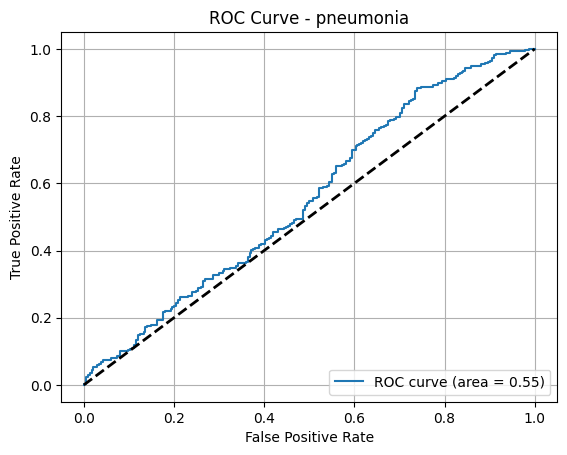

Task: pneumonia
Loss: 0.6798, Accuracy: 5.0000
Precision: 0.6250, Recall: 1.0000, F1 Score: 0.7692
Confusion Matrix: 
[[  0 234]
 [  0 390]]
ROC-AUC: 0.5538




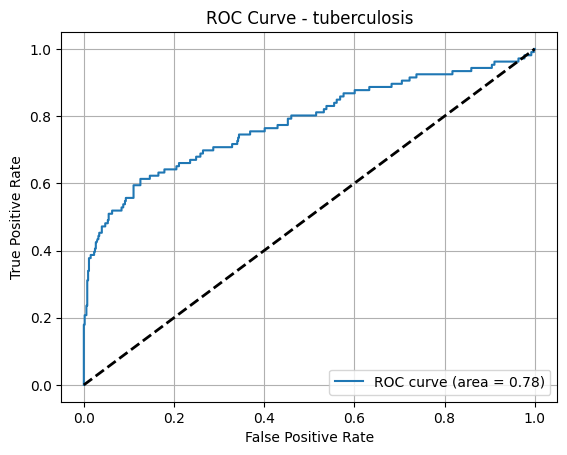

Task: tuberculosis
Loss: 0.8219, Accuracy: 1.3418
Precision: 0.1677, Recall: 1.0000, F1 Score: 0.2873
Confusion Matrix: 
[[  0 526]
 [  0 106]]
ROC-AUC: 0.7807




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


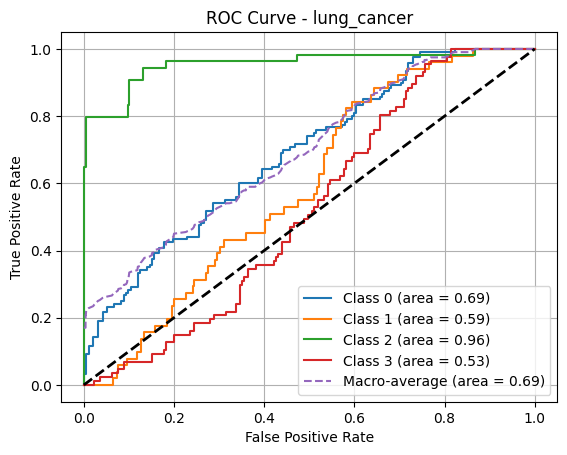

Task: lung_cancer
Loss: 1.9837, Accuracy: 0.1859
Precision: 0.0753, Recall: 0.2615, F1 Score: 0.0987
Confusion Matrix: 
[[ 0  1 91 28]
 [ 0  0 44  7]
 [ 0  0 54  0]
 [ 0  0 83  4]]
ROC-AUC: 0.6911




In [21]:
# Defining the test loader dictionary
test_loader = {
    'pneumonia': data_loaders['Pneumonia']['test_loader'],
    'tuberculosis': data_loaders['Tuberculosis']['test_loader'],
    'lung_cancer': data_loaders['Lung Cancer']['test_loader']
}

# Calling the test_model function
test_model(model, test_loader, device)

<br>
<br>

### <b>STEP - 7 : Model Saving</b>

In [22]:
# Saving the best model to disk
torch.save(model.state_dict(), "model_FINAL.pth")
print("Saved the best model to './model_FINAL.pth'")

Saved the best model to '/content/drive/MyDrive/CVIP_PROJ_model.pth'
